In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='4'

## Da fare
1. Car model classification:
   - entire car images vs **car parts**
   - specific viewpoint vs all viewpoints
2. **Car make classification**
3. **Attribute Prediction:**
   - Sum of square loss for continuous attributes
   - Logistic loss for for discrete attributes
   - Trained of the first set and tested on the second 

In [20]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
import importlib
from pathlib import Path
import re

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d
from torch.nn import SiLU as ReLU
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Resize
import torch

from dataset import *
from utils import *
from ResNet18_blocks import *
from ResNet50_blocks import *
from training_functions import *

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [21]:
# import utils
# import dataset 
# import ResNet50_blocks 
# import ResNet18_blocks
# importlib.reload(utils)
# importlib.reload(dataset)
# importlib.reload(ResNet18_blocks)
# importlib.reload(ResNet50_blocks);

# Neural Network and Deep Learning Project

*Alberto Salvador, Volpi Gaia*



In [22]:
#volume_dir = "/mnt/shared_volume/"
volume_dir = "/mnt/home/u0053/disk/gaia_dataset/CompCars/"

In [5]:
# create folder inside volume dir 
for vp in range(6):
    if not os.path.exists(volume_dir + f'{vp}/'):
        os.makedirs(volume_dir + f'{vp}/')

In [ ]:
! ls /mnt/shared_volume/data/train_test_split/classification

ls: cannot access 'volume_dir': No such file or directory
ls: cannot access '+': No such file or directory
ls: cannot access '/data/train_test_split/classification': No such file or directory


## 1. Dataset

Qui sotto si crea il dataset per fare il training su tutti i viewpoints!!

In [24]:
label_to_index = indexing_labels(volume_dir+"data/train_test_split/classification/train.txt")
print("Nr of models in the train dataset: ", len(label_to_index))

Nr of models in the train dataset:  431


In [25]:
transforms_train = Compose([
    Resize((224, 224)), 
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

In [26]:
make_dataset = dataset_factory(volume_dir, label_to_index, transforms_train, transforms) # serve per creare la factory che genera i dataset
VIEWPOINT = None
train_dataset, test_dataset, valid_dataset =  make_dataset(VIEWPOINT) # carino perchè devi passare solo il viewpoint

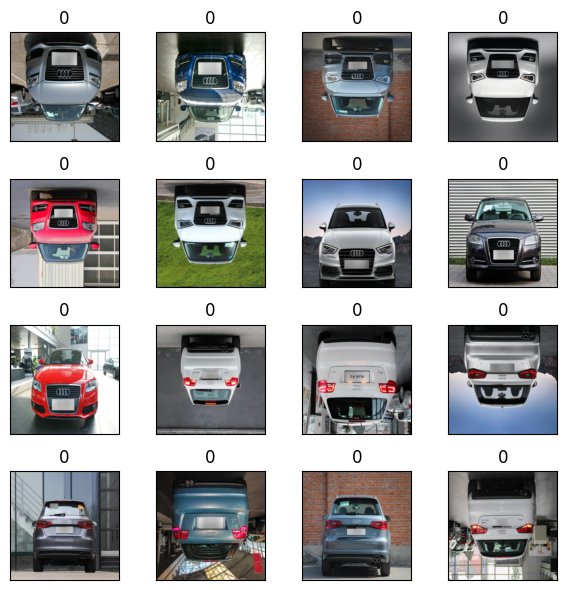

In [28]:
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"{train_dataset[i][1]}")
plt.tight_layout()

In [29]:
print(f'train dataset: {len(train_dataset)} \ntest dataset: {len(test_dataset)} \nvalid dataset: {len(valid_dataset)}')

train dataset: 16016 
test dataset: 7470 
valid dataset: 7469


In [30]:
# Here we use the Dataloader function from pytorch to opportunely split the dataset in batches and shuffling data
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())

In [13]:
#class weights
# labels_array = []
# for batch in train_dataloader:
#     _, labels = batch
#     labels_array.append(labels)
# labels_array = torch.cat(labels_array).numpy().astype(int)
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_array), y=labels_array)

In [14]:
#check_unbalance_dataset(valid_dataloader, n_indices=3000, title='validation set')

In [15]:
#check_unbalance_dataset(train_dataloader, n_indices=3000, title='training set')

In [16]:
#check_unbalance_dataset(valid_dataloader, n_indices=3000, title='valid set')

## 2. Training 

We have implemented two different architectures:
- ResNet50
- ResNet 18

We will proceed with ResNet18 now!

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet18()
optimizer = Adam(params=model.parameters(), lr=3e-4, weight_decay=5e-4)
loss = CrossEntropyLoss
epochs = 200

### 2.1 Training on all viewpoints
when: vp=None or '0'

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet18()
optimizer = Adam(params=model.parameters(), lr=3e-4, weight_decay=5e-4)
train_loss_log, val_loss_log = network_training(
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    load_checkpoint=load_checkpoint(
        load=True, 
        model=model,
        opt=Adam(params=model.parameters(), lr=3e-4, weight_decay=5e-4), 
        device=device, 
        volume_dir=volume_dir
    ),
    loss_fn=fix_losses(calcul_class_weights(train_dataloader), CrossEntropyLoss, device),
    device=device,
    epochs=epochs,
    save_checkpoint=lambda model, opt: save_checkpoint(model, opt, VIEWPOINT or "0", volume_dir),
    save_metric=lambda metric, values: store_metric(volume_dir)(metric, values, VIEWPOINT)
)

Epoch: 1


100%|██████████| 39/39 [00:09<00:00,  3.98it/s]


loss: 5.840731620788574, accuracy: 0.008836524561047554
Model and optimizer state saved.
Epoch: 2


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 5.734840393066406, accuracy: 0.010175391100347042
Model and optimizer state saved.
Epoch: 3


100%|██████████| 39/39 [00:09<00:00,  4.08it/s]


loss: 5.722166538238525, accuracy: 0.010175391100347042
Model and optimizer state saved.
Epoch: 4


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 5.614075183868408, accuracy: 0.01566474698483944
Model and optimizer state saved.
Epoch: 5


100%|██████████| 39/39 [00:10<00:00,  3.83it/s]


loss: 5.512979030609131, accuracy: 0.01673584058880806
Model and optimizer state saved.
Epoch: 6


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 5.429453372955322, accuracy: 0.02316240407526493
Model and optimizer state saved.
Epoch: 7


100%|██████████| 39/39 [00:09<00:00,  3.90it/s]


loss: 5.402599811553955, accuracy: 0.024501271545886993
Model and optimizer state saved.
Epoch: 8


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 5.427860736846924, accuracy: 0.02731289342045784
Epoch: 9


100%|██████████| 39/39 [00:10<00:00,  3.85it/s]


loss: 5.2470383644104, accuracy: 0.03373945504426956
Model and optimizer state saved.
Epoch: 10


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 5.115085124969482, accuracy: 0.04391484707593918
Model and optimizer state saved.
Epoch: 11


100%|██████████| 39/39 [00:09<00:00,  3.97it/s]


loss: 5.075483322143555, accuracy: 0.05569687858223915
Model and optimizer state saved.
Epoch: 12


100%|██████████| 39/39 [00:09<00:00,  3.97it/s]


loss: 4.983949184417725, accuracy: 0.05850850045681
Model and optimizer state saved.
Epoch: 13


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 5.095392227172852, accuracy: 0.052081938832998276
Epoch: 14


100%|██████████| 39/39 [00:09<00:00,  4.11it/s]


loss: 4.865035057067871, accuracy: 0.07136162370443344
Model and optimizer state saved.
Epoch: 15


100%|██████████| 39/39 [00:10<00:00,  3.75it/s]


loss: 4.804859638214111, accuracy: 0.07725264132022858
Model and optimizer state saved.
Epoch: 16


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 4.671756267547607, accuracy: 0.09264961630105972
Model and optimizer state saved.
Epoch: 17


100%|██████████| 39/39 [00:09<00:00,  4.04it/s]


loss: 4.660139083862305, accuracy: 0.09104297310113907
Model and optimizer state saved.
Epoch: 18


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 4.616689682006836, accuracy: 0.09680010378360748
Model and optimizer state saved.
Epoch: 19


100%|██████████| 39/39 [00:09<00:00,  4.01it/s]


loss: 4.6506218910217285, accuracy: 0.10550273954868317
Epoch: 20


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 4.5211501121521, accuracy: 0.11380372196435928
Model and optimizer state saved.
Epoch: 21


100%|██████████| 39/39 [00:09<00:00,  4.03it/s]


loss: 4.550932884216309, accuracy: 0.11474093049764633
Epoch: 22


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 4.419284343719482, accuracy: 0.12799571454524994
Model and optimizer state saved.
Epoch: 23


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 4.656590938568115, accuracy: 0.10416387766599655
Epoch: 24


100%|██████████| 39/39 [00:10<00:00,  3.88it/s]


loss: 4.384647369384766, accuracy: 0.13107511401176453
Model and optimizer state saved.
Epoch: 25


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 4.4785614013671875, accuracy: 0.132681742310524
Epoch: 26


100%|██████████| 39/39 [00:10<00:00,  3.83it/s]


loss: 4.149402141571045, accuracy: 0.16655509173870087
Model and optimizer state saved.
Epoch: 27


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 4.212063312530518, accuracy: 0.15571026504039764
Epoch: 28


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 4.156691551208496, accuracy: 0.15490694344043732
Epoch: 29


100%|██████████| 39/39 [00:09<00:00,  4.03it/s]


loss: 4.009514808654785, accuracy: 0.17833712697029114
Model and optimizer state saved.
Epoch: 30


100%|██████████| 39/39 [00:10<00:00,  3.90it/s]


loss: 4.073363304138184, accuracy: 0.17552550137043
Epoch: 31


100%|██████████| 39/39 [00:09<00:00,  3.97it/s]


loss: 3.999504566192627, accuracy: 0.18489757180213928
Model and optimizer state saved.
Epoch: 32


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 3.8982019424438477, accuracy: 0.19855402410030365
Model and optimizer state saved.
Epoch: 33


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 3.984105110168457, accuracy: 0.1806132048368454
Epoch: 34


100%|██████████| 39/39 [00:10<00:00,  3.83it/s]


loss: 4.054018020629883, accuracy: 0.18449591100215912
Epoch: 35


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 3.7856078147888184, accuracy: 0.21408487856388092
Model and optimizer state saved.
Epoch: 36


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 3.8473687171936035, accuracy: 0.2001606673002243
Epoch: 37


100%|██████████| 39/39 [00:09<00:00,  4.02it/s]


loss: 3.867548942565918, accuracy: 0.20631945133209229
Epoch: 38


100%|██████████| 39/39 [00:09<00:00,  4.02it/s]


loss: 3.6434009075164795, accuracy: 0.23738117516040802
Model and optimizer state saved.
Epoch: 39


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 3.7395269870758057, accuracy: 0.23041905462741852
Epoch: 40


100%|██████████| 39/39 [00:09<00:00,  3.91it/s]


loss: 3.584693670272827, accuracy: 0.25063595175743103
Model and optimizer state saved.
Epoch: 41


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 3.6415510177612305, accuracy: 0.24179942905902863
Epoch: 42


100%|██████████| 39/39 [00:10<00:00,  3.85it/s]


loss: 3.6758861541748047, accuracy: 0.2384522706270218
Epoch: 43


100%|██████████| 39/39 [00:09<00:00,  4.01it/s]


loss: 3.4332377910614014, accuracy: 0.27339670062065125
Model and optimizer state saved.
Epoch: 44


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 3.73500919342041, accuracy: 0.24273663759231567
Epoch: 45


100%|██████████| 39/39 [00:10<00:00,  3.88it/s]


loss: 3.7620689868927, accuracy: 0.23778283596038818
Epoch: 46


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 3.3571534156799316, accuracy: 0.28035882115364075
Model and optimizer state saved.
Epoch: 47


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 3.300464391708374, accuracy: 0.29535412788391113
Model and optimizer state saved.
Epoch: 48


100%|██████████| 39/39 [00:09<00:00,  3.91it/s]


loss: 3.457663059234619, accuracy: 0.2695139944553375
Epoch: 49


100%|██████████| 39/39 [00:10<00:00,  3.90it/s]


loss: 3.3294196128845215, accuracy: 0.29736241698265076
Epoch: 50


100%|██████████| 39/39 [00:10<00:00,  3.82it/s]


loss: 3.337055206298828, accuracy: 0.28799036145210266
Epoch: 51


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 3.217395067214966, accuracy: 0.3159726858139038
Model and optimizer state saved.
Epoch: 52


100%|██████████| 39/39 [00:09<00:00,  4.05it/s]


loss: 3.2200732231140137, accuracy: 0.30432453751564026
Epoch: 53


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 3.2948436737060547, accuracy: 0.3107511103153229
Epoch: 54


100%|██████████| 39/39 [00:09<00:00,  3.91it/s]


loss: 3.057356595993042, accuracy: 0.33123576641082764
Model and optimizer state saved.
Epoch: 55


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 3.264350652694702, accuracy: 0.31235775351524353
Epoch: 56


100%|██████████| 39/39 [00:10<00:00,  3.84it/s]


loss: 3.0933315753936768, accuracy: 0.3333779573440552
Epoch: 57


100%|██████████| 39/39 [00:09<00:00,  3.98it/s]


loss: 3.1121318340301514, accuracy: 0.3277547061443329
Epoch: 58


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 3.11995792388916, accuracy: 0.3302985727787018
Epoch: 59


100%|██████████| 39/39 [00:10<00:00,  3.88it/s]


loss: 3.1938400268554688, accuracy: 0.3195876181125641
Epoch: 60


100%|██████████| 39/39 [00:09<00:00,  4.03it/s]


loss: 2.9512126445770264, accuracy: 0.3485071659088135
Model and optimizer state saved.
Epoch: 61


100%|██████████| 39/39 [00:10<00:00,  3.82it/s]


loss: 3.076648712158203, accuracy: 0.34328556060791016
Epoch: 62


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 2.9852287769317627, accuracy: 0.36216360330581665
Epoch: 63


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 2.842200994491577, accuracy: 0.36966127157211304
Model and optimizer state saved.
Epoch: 64


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 2.9426558017730713, accuracy: 0.3586825430393219
Epoch: 65


100%|██████████| 39/39 [00:09<00:00,  3.99it/s]


loss: 2.715101718902588, accuracy: 0.39536750316619873
Model and optimizer state saved.
Epoch: 66


100%|██████████| 39/39 [00:09<00:00,  3.98it/s]


loss: 2.902912139892578, accuracy: 0.36725130677223206
Epoch: 67


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


loss: 2.9842722415924072, accuracy: 0.3586825430393219
Epoch: 68


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 2.7349605560302734, accuracy: 0.38304993510246277
Epoch: 69


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


loss: 2.7070443630218506, accuracy: 0.4025973975658417
Model and optimizer state saved.
Epoch: 70


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 2.811901330947876, accuracy: 0.3739456236362457
Epoch: 71


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 2.7093117237091064, accuracy: 0.39670637249946594
Epoch: 72


100%|██████████| 39/39 [00:09<00:00,  3.90it/s]


loss: 2.5862183570861816, accuracy: 0.42883920669555664
Model and optimizer state saved.
Epoch: 73


100%|██████████| 39/39 [00:10<00:00,  3.88it/s]


loss: 2.598299980163574, accuracy: 0.4189315736293793
Epoch: 74


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 2.7517213821411133, accuracy: 0.3989824652671814
Epoch: 75


100%|██████████| 39/39 [00:10<00:00,  3.85it/s]


loss: 2.546308994293213, accuracy: 0.4284375309944153
Model and optimizer state saved.
Epoch: 76


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


loss: 2.6605141162872314, accuracy: 0.4076851010322571
Epoch: 77


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 2.4987926483154297, accuracy: 0.4329896867275238
Model and optimizer state saved.
Epoch: 78


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 2.66648268699646, accuracy: 0.4079528748989105
Epoch: 79


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 2.474257230758667, accuracy: 0.44142454862594604
Model and optimizer state saved.
Epoch: 80


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 2.614297866821289, accuracy: 0.41370999813079834
Epoch: 81


100%|██████████| 39/39 [00:09<00:00,  3.91it/s]


loss: 2.544508218765259, accuracy: 0.4321863651275635
Epoch: 82


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 2.5054702758789062, accuracy: 0.4362029731273651
Epoch: 83


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 2.401221990585327, accuracy: 0.4536082446575165
Model and optimizer state saved.
Epoch: 84


100%|██████████| 39/39 [00:10<00:00,  3.79it/s]


loss: 2.5324714183807373, accuracy: 0.4340607821941376
Epoch: 85


100%|██████████| 39/39 [00:10<00:00,  3.83it/s]


loss: 2.418825626373291, accuracy: 0.456152081489563
Epoch: 86


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 2.570056438446045, accuracy: 0.441826194524765
Epoch: 87


100%|██████████| 39/39 [00:10<00:00,  3.78it/s]


loss: 2.432772636413574, accuracy: 0.45347434282302856
Epoch: 88


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


loss: 2.4794511795043945, accuracy: 0.45213547348976135
Epoch: 89


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 2.493006467819214, accuracy: 0.4379434883594513
Epoch: 90


100%|██████████| 39/39 [00:09<00:00,  4.01it/s]


loss: 2.625577688217163, accuracy: 0.4210737645626068
Epoch: 91


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 2.4247114658355713, accuracy: 0.4569554030895233
Epoch: 92


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 2.5707061290740967, accuracy: 0.43767571449279785
Epoch: 93


100%|██████████| 39/39 [00:10<00:00,  3.76it/s]


loss: 2.380319118499756, accuracy: 0.458160400390625
Model and optimizer state saved.
Epoch: 94


100%|██████████| 39/39 [00:09<00:00,  3.99it/s]


loss: 2.46401047706604, accuracy: 0.44517338275909424
Epoch: 95


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


loss: 2.3220198154449463, accuracy: 0.47422680258750916
Model and optimizer state saved.
Epoch: 96


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 2.4534573554992676, accuracy: 0.45963314175605774
Epoch: 97


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 2.21832013130188, accuracy: 0.48359885811805725
Model and optimizer state saved.
Epoch: 98


100%|██████████| 39/39 [00:10<00:00,  3.78it/s]


loss: 2.366727113723755, accuracy: 0.46605971455574036
Epoch: 99


100%|██████████| 39/39 [00:10<00:00,  3.88it/s]


loss: 2.1666781902313232, accuracy: 0.5007363557815552
Model and optimizer state saved.
Epoch: 100


100%|██████████| 39/39 [00:10<00:00,  3.90it/s]


loss: 2.3927884101867676, accuracy: 0.47275403141975403
Epoch: 101


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 2.4325950145721436, accuracy: 0.4562859833240509
Epoch: 102


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 2.202430248260498, accuracy: 0.4916320741176605
Epoch: 103


100%|██████████| 39/39 [00:09<00:00,  3.97it/s]


loss: 2.3121752738952637, accuracy: 0.4787789583206177
Epoch: 104


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 2.417433023452759, accuracy: 0.4538760185241699
Epoch: 105


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 2.1965081691741943, accuracy: 0.49698755145072937
Epoch: 106


100%|██████████| 39/39 [00:09<00:00,  4.13it/s]


loss: 2.5419723987579346, accuracy: 0.4423617422580719
Epoch: 107


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 2.141495704650879, accuracy: 0.5030124187469482
Model and optimizer state saved.
Epoch: 108


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 2.2179644107818604, accuracy: 0.48882046341896057
Epoch: 109


100%|██████████| 39/39 [00:09<00:00,  4.01it/s]


loss: 2.1108558177948, accuracy: 0.5043513178825378
Model and optimizer state saved.
Epoch: 110


100%|██████████| 39/39 [00:10<00:00,  3.78it/s]


loss: 2.2109501361846924, accuracy: 0.5012719035148621
Epoch: 111


100%|██████████| 39/39 [00:09<00:00,  4.10it/s]


loss: 2.147441864013672, accuracy: 0.49123039841651917
Epoch: 112


100%|██████████| 39/39 [00:10<00:00,  3.75it/s]


loss: 2.254316568374634, accuracy: 0.4959164559841156
Epoch: 113


100%|██████████| 39/39 [00:10<00:00,  3.88it/s]


loss: 2.1347496509552, accuracy: 0.5063596367835999
Epoch: 114


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 2.196504831314087, accuracy: 0.4872138202190399
Epoch: 115


100%|██████████| 39/39 [00:10<00:00,  3.90it/s]


loss: 2.1969549655914307, accuracy: 0.5056901574134827
Epoch: 116


100%|██████████| 39/39 [00:09<00:00,  3.91it/s]


loss: 2.143284797668457, accuracy: 0.5066273808479309
Epoch: 117


100%|██████████| 39/39 [00:09<00:00,  3.98it/s]


loss: 2.0823814868927, accuracy: 0.5252376198768616
Model and optimizer state saved.
Epoch: 118


100%|██████████| 39/39 [00:10<00:00,  3.79it/s]


loss: 2.1182382106781006, accuracy: 0.5087695717811584
Epoch: 119


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 2.1342782974243164, accuracy: 0.5138572454452515
Epoch: 120


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 2.3782684803009033, accuracy: 0.47677063941955566
Epoch: 121


100%|██████████| 39/39 [00:10<00:00,  3.83it/s]


loss: 2.16613507270813, accuracy: 0.5133216977119446
Epoch: 122


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 2.0734214782714844, accuracy: 0.5281831622123718
Model and optimizer state saved.
Epoch: 123


100%|██████████| 39/39 [00:10<00:00,  3.75it/s]


loss: 2.1790049076080322, accuracy: 0.5083678960800171
Epoch: 124


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 2.034245252609253, accuracy: 0.5221582651138306
Model and optimizer state saved.
Epoch: 125


100%|██████████| 39/39 [00:09<00:00,  4.03it/s]


loss: 1.9979321956634521, accuracy: 0.5312625169754028
Model and optimizer state saved.
Epoch: 126


100%|██████████| 39/39 [00:09<00:00,  3.98it/s]


loss: 2.106105089187622, accuracy: 0.5244343280792236
Epoch: 127


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 2.3182952404022217, accuracy: 0.48292943835258484
Epoch: 128


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 2.086170196533203, accuracy: 0.5193465948104858
Epoch: 129


100%|██████████| 39/39 [00:10<00:00,  3.81it/s]


loss: 2.0460801124572754, accuracy: 0.5287187099456787
Epoch: 130


100%|██████████| 39/39 [00:09<00:00,  4.02it/s]


loss: 2.080076217651367, accuracy: 0.5292542576789856
Epoch: 131


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 2.063204288482666, accuracy: 0.5155978202819824
Epoch: 132


100%|██████████| 39/39 [00:09<00:00,  4.03it/s]


loss: 2.027283191680908, accuracy: 0.5296558737754822
Epoch: 133


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 1.9951064586639404, accuracy: 0.5378230214118958
Model and optimizer state saved.
Epoch: 134


100%|██████████| 39/39 [00:09<00:00,  4.01it/s]


loss: 2.2534239292144775, accuracy: 0.48426830768585205
Epoch: 135


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 2.0496232509613037, accuracy: 0.5252376198768616
Epoch: 136


100%|██████████| 39/39 [00:09<00:00,  3.90it/s]


loss: 2.2459514141082764, accuracy: 0.48560717701911926
Epoch: 137


100%|██████████| 39/39 [00:09<00:00,  4.04it/s]


loss: 2.1355321407318115, accuracy: 0.5164011120796204
Epoch: 138


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 2.057886838912964, accuracy: 0.5113134384155273
Epoch: 139


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 2.115081548690796, accuracy: 0.5103762149810791
Epoch: 140


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 2.4210383892059326, accuracy: 0.45334047079086304
Epoch: 141


100%|██████████| 39/39 [00:09<00:00,  4.07it/s]


loss: 2.108372926712036, accuracy: 0.5206854939460754
Epoch: 142


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 2.174408435821533, accuracy: 0.5002008080482483
Epoch: 143


100%|██████████| 39/39 [00:09<00:00,  4.02it/s]


loss: 2.1228578090667725, accuracy: 0.5145267248153687
Epoch: 144


100%|██████████| 39/39 [00:09<00:00,  3.90it/s]


loss: 1.9984015226364136, accuracy: 0.5331369638442993
Epoch: 145


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 2.099449634552002, accuracy: 0.5121167302131653
Epoch: 146


100%|██████████| 39/39 [00:09<00:00,  3.98it/s]


loss: 2.060547351837158, accuracy: 0.5267103910446167
Epoch: 147


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 2.027366876602173, accuracy: 0.5243004560470581
Epoch: 148


100%|██████████| 39/39 [00:10<00:00,  3.85it/s]


loss: 2.213245391845703, accuracy: 0.5014057755470276
Epoch: 149


100%|██████████| 39/39 [00:09<00:00,  4.06it/s]


loss: 2.042322874069214, accuracy: 0.523095428943634
Epoch: 150


100%|██████████| 39/39 [00:09<00:00,  3.97it/s]


loss: 1.8937124013900757, accuracy: 0.5530861020088196
Model and optimizer state saved.
Epoch: 151


100%|██████████| 39/39 [00:09<00:00,  4.09it/s]


loss: 2.250199794769287, accuracy: 0.49123039841651917
Epoch: 152


100%|██████████| 39/39 [00:09<00:00,  3.90it/s]


loss: 2.008369207382202, accuracy: 0.5301914215087891
Epoch: 153


100%|██████████| 39/39 [00:09<00:00,  4.08it/s]


loss: 2.0042951107025146, accuracy: 0.5423751473426819
Epoch: 154


100%|██████████| 39/39 [00:09<00:00,  4.04it/s]


loss: 1.9432953596115112, accuracy: 0.546659529209137
Epoch: 155


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 1.9917659759521484, accuracy: 0.5362163782119751
Epoch: 156


100%|██████████| 39/39 [00:09<00:00,  3.90it/s]


loss: 2.04247784614563, accuracy: 0.5275137424468994
Epoch: 157


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 1.9974312782287598, accuracy: 0.5380907654762268
Epoch: 158


100%|██████████| 39/39 [00:09<00:00,  3.91it/s]


loss: 2.0288760662078857, accuracy: 0.5244343280792236
Epoch: 159


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 1.9717645645141602, accuracy: 0.5431784391403198
Epoch: 160


100%|██████████| 39/39 [00:10<00:00,  3.84it/s]


loss: 1.9867316484451294, accuracy: 0.536751925945282
Epoch: 161


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 2.0060997009277344, accuracy: 0.5411701798439026
Epoch: 162


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 2.0350475311279297, accuracy: 0.5301914215087891
Epoch: 163


100%|██████████| 39/39 [00:10<00:00,  3.88it/s]


loss: 1.9504889249801636, accuracy: 0.5419734716415405
Epoch: 164


100%|██████████| 39/39 [00:09<00:00,  4.02it/s]


loss: 2.0908796787261963, accuracy: 0.5031463503837585
Epoch: 165


100%|██████████| 39/39 [00:09<00:00,  3.91it/s]


loss: 2.018357992172241, accuracy: 0.529923677444458
Epoch: 166


100%|██████████| 39/39 [00:10<00:00,  3.84it/s]


loss: 1.9438973665237427, accuracy: 0.5387601852416992
Epoch: 167


100%|██████████| 39/39 [00:10<00:00,  3.82it/s]


loss: 1.8985097408294678, accuracy: 0.5530861020088196
Epoch: 168


100%|██████████| 39/39 [00:09<00:00,  3.97it/s]


loss: 1.9031624794006348, accuracy: 0.5565671324729919
Epoch: 169


100%|██████████| 39/39 [00:09<00:00,  4.09it/s]


loss: 1.932401418685913, accuracy: 0.5475967526435852
Epoch: 170


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


loss: 1.9473565816879272, accuracy: 0.5470612049102783
Epoch: 171


100%|██████████| 39/39 [00:10<00:00,  3.83it/s]


loss: 1.9281461238861084, accuracy: 0.5508099794387817
Epoch: 172


100%|██████████| 39/39 [00:09<00:00,  3.97it/s]


loss: 1.9987661838531494, accuracy: 0.5312625169754028
Epoch: 173


100%|██████████| 39/39 [00:10<00:00,  3.84it/s]


loss: 1.9426867961883545, accuracy: 0.5458561778068542
Epoch: 174


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 2.011772871017456, accuracy: 0.5336725115776062
Epoch: 175


100%|██████████| 39/39 [00:09<00:00,  3.98it/s]


loss: 2.123736619949341, accuracy: 0.5078323483467102
Epoch: 176


100%|██████████| 39/39 [00:10<00:00,  3.85it/s]


loss: 2.0499634742736816, accuracy: 0.5253715515136719
Epoch: 177


100%|██████████| 39/39 [00:09<00:00,  4.01it/s]


loss: 2.0410819053649902, accuracy: 0.5281831622123718
Epoch: 178


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 1.94973886013031, accuracy: 0.5548266172409058
Epoch: 179


100%|██████████| 39/39 [00:09<00:00,  3.91it/s]


loss: 1.914205551147461, accuracy: 0.5583076477050781
Epoch: 180


100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


loss: 1.9477990865707397, accuracy: 0.5459901094436646
Epoch: 181


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 1.8808646202087402, accuracy: 0.5584415197372437
Model and optimizer state saved.
Epoch: 182


100%|██████████| 39/39 [00:09<00:00,  3.98it/s]


loss: 1.9865014553070068, accuracy: 0.5303253531455994
Epoch: 183


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 1.9115744829177856, accuracy: 0.5441156625747681
Epoch: 184


100%|██████████| 39/39 [00:10<00:00,  3.82it/s]


loss: 1.8383044004440308, accuracy: 0.5640648007392883
Model and optimizer state saved.
Epoch: 185


100%|██████████| 39/39 [00:10<00:00,  3.85it/s]


loss: 2.0465993881225586, accuracy: 0.5340741872787476
Epoch: 186


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 1.9405523538589478, accuracy: 0.5441156625747681
Epoch: 187


100%|██████████| 39/39 [00:09<00:00,  3.97it/s]


loss: 1.8763024806976318, accuracy: 0.5530861020088196
Epoch: 188


100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


loss: 2.032827138900757, accuracy: 0.5245682001113892
Epoch: 189


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


loss: 1.9591171741485596, accuracy: 0.5375552177429199
Epoch: 190


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 1.8755465745925903, accuracy: 0.5542910695075989
Epoch: 191


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


loss: 1.9232054948806763, accuracy: 0.5410362482070923
Epoch: 192


100%|██████████| 39/39 [00:09<00:00,  3.90it/s]


loss: 1.9110726118087769, accuracy: 0.5417057275772095
Epoch: 193


100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


loss: 2.047588348388672, accuracy: 0.5192127227783203
Epoch: 194


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]


loss: 1.8934118747711182, accuracy: 0.5516133308410645
Epoch: 195


100%|██████████| 39/39 [00:09<00:00,  3.95it/s]


loss: 1.941584825515747, accuracy: 0.53474360704422
Epoch: 196


100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


loss: 1.9413516521453857, accuracy: 0.5354130268096924
Epoch: 197


100%|██████████| 39/39 [00:10<00:00,  3.79it/s]


loss: 1.9919922351837158, accuracy: 0.5356808304786682
Epoch: 198


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


loss: 1.9761663675308228, accuracy: 0.5386263132095337
Epoch: 199


100%|██████████| 39/39 [00:09<00:00,  3.90it/s]


loss: 2.030803680419922, accuracy: 0.5276476144790649
Epoch: 200


100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


loss: 1.9999628067016602, accuracy: 0.5354130268096924


AttributeError: 'float' object has no attribute 'extend'

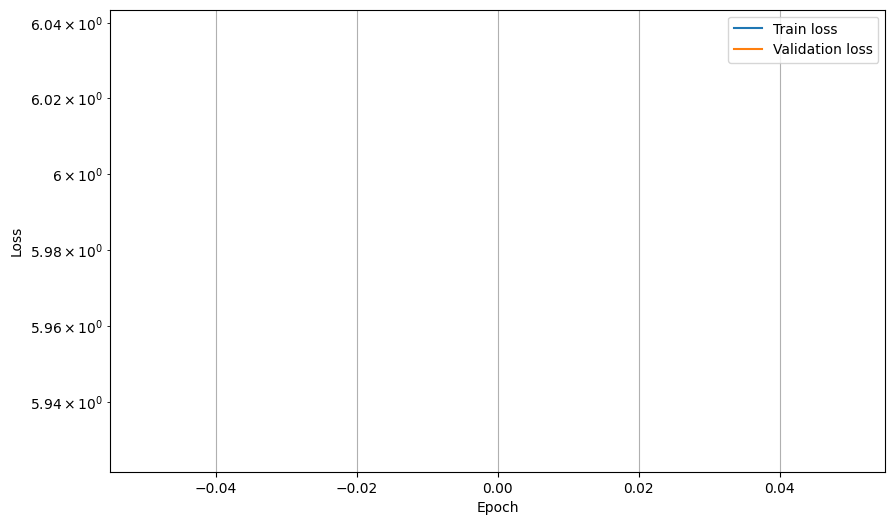

In [ ]:
train_loss_log = np.loadtxt(volume_dir+str(VIEWPOINT or '0')+'/train_loss_log.txt').tolist()
val_loss_log = np.loadtxt(volume_dir+str(VIEWPOINT or '0')+'/val_loss_log.txt').tolist()
plot_losses(train_loss_log, val_loss_log)

### 2.2 Training on different viewpoints

In [18]:
metrics = multi_viewpoint_training(
    viewpoints=[None,1,2,3,4,5], 
    epochs=epochs, 
    make_dataset=make_dataset,
    load_checkpoint=load_checkpoint(
        load=False, 
        model=model,
        opt=optimizer, 
        device=device, 
        volume_dir=volume_dir
    ), 
    loss_fn=lambda class_weights: fix_losses(class_weights, loss, device), 
    device=device, 
    save_checkpoint=lambda model, opt, viewpoint: save_checkpoint(model, opt, viewpoint or "0", volume_dir), 
    load_pretrain=lambda device, model, vp :load_pretrain(volume_dir, device, model, None, vp=vp),
    save_metric=store_metric(volume_dir), 
    model_class=type(model), 
    k_list=[1,5]
)

Epoch: 1


100%|██████████| 39/39 [00:09<00:00,  4.10it/s]


loss: 5.9273881912231445, accuracy: 0.005489355884492397
Model and optimizer state saved.


100%|██████████| 39/39 [00:08<00:00,  4.61it/s]


	top-1 score: 0.010
	top-5 score: 0.036
Epoch: 1


100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


loss: 5.9235663414001465, accuracy: 0.008438818156719208
Model and optimizer state saved.


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

	top-1 score: 0.008
	top-5 score: 0.033
